In [173]:
__author__ = 'David Herrera <david.herrera@noirlab.edu>, and the Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20240821' # yyyymmdd
__datasets__ = ['ls_dr6','ls_dr7','ls_dr8','ls_dr9']
__keywords__ = ['extragalactic','galaxies','joint query','legacy survey','desi']
__nbid__ = 'nb0068'

# DESI Legacy Imaging Survey (LIS) 
## Coverage, Magnitudes and comparison with AllWISE 

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Survey Coverage](#Fig2)
* [Forced mid-infrared photometry](#Fig8)
* [Depth distribution of point sources](#Fig15)
* [Color-color Distribution by Type of Extended Objects](#Fig16)
* [Resources and References](#resources)

<a class="anchor" id="goals"></a>
# Goals
* Reproduce plots published in the DESI LIS overview paper (Dey et al., 2019) using tables we were or are serving in our Data Lab database and resources in our Data Lab service. We'll be using in particular the datasets DESI Legacy Survey DR6, DR7, DR8.
* Compare some of them with the latest, most stable data releases. DR9 in this case.

# Summary

**Background**

We wanted to reproduce science results obtained in a published and refereed paper that has used datasets that are included and openly serviced by Data Lab. We settled in this one that has used datasets from 2019.

**Data retrieval**
We used catalogs from the DESI Legacy Imaging Survey DR6, DR7 (both retired), DR8 & DR9 (the latest more complete and stable DR) in order to update and compare results.

In this Notebook, we take on the mission to recreate 4 plots that were published in the paper "Overview of the DESI Legacy Imaging Surveys" (Dey et al, AJ, 2019) using our Data Lab database, where the catalogs eventually used for these figures are saved.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup

In [157]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
from astropy.table import Table
from astropy import units as u
import pandas as pd

# Data Lab
from dl import queryClient as qc
from dl import authClient as ac

print('Done importing')

Done importing


In [6]:
# Uncomment the next 3 lines in case authentication is needed:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
if not ac.isValidToken(token):
    raise Exception('Token is not valid. Please check your usename/password and execute this cell again.')

Enter user name: (+ENTER)  davalfher
Enter password: (+ENTER)  ········


<a class="anchor" id="Fig2"></a>
## Fig. 2 - Image coverage of the DESI Legacy Imaging Surveys
Figure 2 consists of an all-sky map of the coverage of the DESI LIS. We use the data from the DR8 to build a map with what is contained in that data release, by considering the size and number of bricks and adding them onto the all-sky map. DR7 does not contain the northern part of the LIS (from the MLzS & BASS surveys)

We created a csv file out of the tractor table of ls_dr8 that can be re-created by running this query in the PSQL prompt:


In [ ]:
# query_fig2 = ("""
# SELECT avg(ra) as ra0, avg(dec) as dec0, nest4096, count(nest4096) as n
# FROM ls_dr8.tractor GROUP BY nest4096
# """)

or by running an asyncronous query with the query client, for example, in the form

In [ ]:
# catalog = qc.query(sql=query_fig2, async=True, fmt='pandas')
# Saving the data frame to a csv file with header:
# table = catalog.to_csv('catalog.csv', encoding='utf-8', index=False)

which will take several hours and you can later save it in your mydb space.

The query can not be run or the file created in our notebooks since it takes several hours and the returned table file is very large (4.6GB) to be kept around.
So before plotting, we will save the actual map data into a fits table which can be read and the map reproduced by using its data.

We defined next a couple of functions for the manipulation of data that goes into making the map

In [ ]:
# UNCOMMENT THIS AND THE FOLLOWING 2 CELLS in case you are getting the query via the queryClient 
# or you are reading the data from the csv file
#def compute_survey_area(df,res=12):
#    areasky = ((360*u.deg)**2)/np.pi
#    nside = 2**res
#    npix = 12*nside**2
#    areapix = areasky / npix
#    areasurvey = df.shape[0]*areapix
#    return areapix, areasurvey

#def compute_healpix_map(df,areapix,newnside=None):
#    tmap = np.zeros(hp.nside2npix(4096))
#    tmap[df['nest4096']] = df['n']/areapix
#    if newnside is not None:     
#        tmap = hp.ud_grade(tmap,newnside,order_in='NESTED',order_out='NESTED')
#    return tmap

We would now read the data either from the large file created with the query above or from the smaller file containing the actual map data:

In [ ]:
# This was the csv from where the map data was taken. It is too big (4.6 GB) to be
# kept around.
# df = pd.read_csv('/dlusers/davalfher/notebooks/NewScienceCase/dataDR8_fig2.csv',usecols=['nest4096','n'])

In [3]:
# Here we compute the actual map after the csv was read
# areapix, areasurvey = compute_survey_area(df)

# m = compute_healpix_map(df,areapix,newnside=2048);

If we already have the healpy fits file already saved, we read the data from it next

In [5]:
# Store the map data in healpy fits it case it doesn't exist yet, 
# so it can be read later from this much smaller file.
# Uncomment the next line and run the cell if you haven't saved it yet
#
# hp.write_map("map_fig2.fits", m, overwrite=True)
# If the healpy map data has been saved already, uncomment the next line and run this cell:
m = hp.read_map("map_fig2.fits")

Now, we finally plot our map

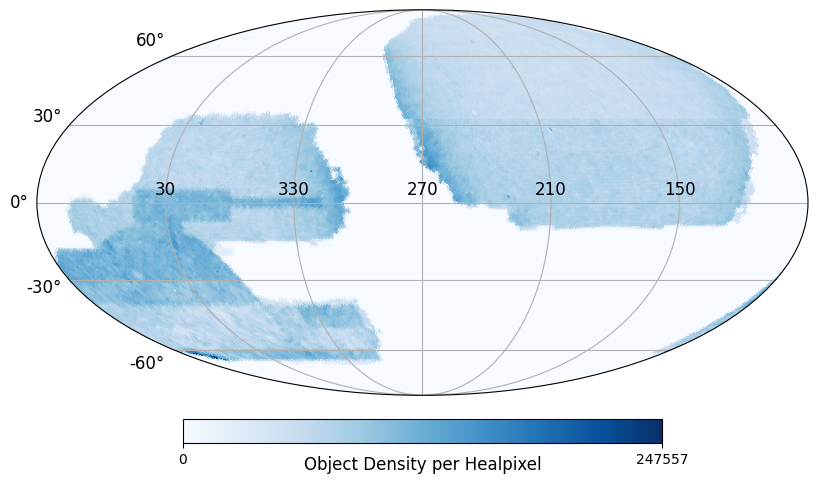

In [6]:
# Here we plot the map
fig2 = hp.projview(m, 
            projection_type='mollweide',
            rot=(-90,0,0),coord='C',
            nest=True,
            cmap='Blues',
            graticule=True,
            graticule_labels=True,
            custom_xtick_labels=["30","330","270","210","150"],
            unit=r'Object Density per Healpixel'
           )

In [ ]:
# Here we plot the map
fig2 = hp.projview(m2, 
            projection_type='mollweide',
            rot=(-90,0,0),coord='C',
            nest=True,
            cmap='Blues',
            graticule=True,
            graticule_labels=True,
            custom_xtick_labels=["30","330","270","210","150"],
            unit=r'Object Density per Healpixel'
           )

<a class="anchor" id="Fig8"></a>
## Fig. 8 - LS and Wise mid-infrared (W1) comparisons 

The Legacy Survey obtains forced photometry with [The Tractor](https://thetractor.org/about/) code. In the following plot, we compare it to the WISE photometry.

First, we obtain and manipulate the data for the left side of the plot 
#### LS W1 vs AllWISE W1

In [68]:
# IMPORTANT: THIS IS THE QUERY USED TO PULL THE DATA FROM THE DATABASE BUT
# IT SHOULD BE COMMENTED OUT AND LEFT AS SUCH SINCE THESE TABLES WILL NOT BE
# SERVICED ANY MORE BY DATALAB

# Query to obtain necessary data by crossmatching both LS and AllWISE catalogs. 
# The photometry in LS and AllWise use different reference system. 
# Legacy Survey uses AB and AllWISE uses Vega, so we do the corresponding conversion 
# in the query itself:

qc.set_profile('db03')

query_fig8 = ("""
select a.designation,l.ra, l.dec, l.mag_w1 - 2.699 as mag_w1, l.random_id as random_id, 
a.w1mpro as w1mpro
from nbdata.nb0068_lsdr7_tractor as l, allwise.source as a
where q3c_radial_query(a.ra,a.dec,l.ra,l.dec,1/3600.) 
AND l.ra BETWEEN 120 AND 250
AND l.random_id between 45 and 65 
limit 160000
""")

print (query_fig8)


select a.designation,l.ra, l.dec, l.mag_w1 - 2.699 as mag_w1, l.random_id as random_id, 
a.w1mpro as w1mpro
from nbdata.nb0068_lsdr7_tractor as l, allwise.source as a
where q3c_radial_query(a.ra,a.dec,l.ra,l.dec,1/3600.) 
AND l.ra BETWEEN 120 AND 250
AND l.random_id between 45 and 65 
limit 160000



Retrieve the data using the pandas data handling tool

In [69]:
#len(data_awls)
# Fetch the W1 mag from ls_dr7.tractor and from allwise.source
# Change the dbXX to the one you can use (db01 or db03)
#qc.set_profile('db01')
w1_awls = qc.query(sql=query_fig8, fmt='pandas')

In [70]:
#Checking first and last rows of the retrieved table:
w1_awls

,designation,ra,dec,mag_w1,random_id,w1mpro
0,J141759.67-044136.2,214.498621,-4.693331,17.072790,45.000000,17.111
1,J113642.65+172014.5,174.177888,17.337463,17.934492,45.000000,17.462
2,J085804.21+322601.0,134.517584,32.433574,15.769662,45.000004,15.709
3,J110219.73-080422.0,165.582089,-8.072846,16.453225,45.000004,16.373
4,J130502.65+023756.4,196.260953,2.632408,16.603641,45.000004,16.511
...,...,...,...,...,...,...
159995,J093206.26+021403.8,143.026094,2.234395,14.325601,45.283276,14.339
159996,J094020.10+325236.4,145.083950,32.876714,16.813306,45.283276,16.642
159997,J141359.43+052703.7,213.497619,5.451021,14.327354,45.283276,14.486
159998,J144856.40+324729.3,222.235022,32.791483,16.252666,45.283276,16.358


We need to clean the data from undetermined values in the form of infinities and NaNs

In [71]:
# Clean Inf and NaN values:
w1_awls.replace([np.inf, -np.inf], np.nan, inplace=True)
w1_awls.dropna(inplace=True)
data_awls= w1_awls.reset_index(inplace=True, drop=True)
data_awls = w1_awls

We check that some rows must have been dropped

In [72]:
len(data_awls)

159743

In [ ]:
## Uncomment the next lines in case the data is not saved in a file already
# Saving the data frame to a csv file with header:
# table = data_awls.to_csv('data_fig8.csv', encoding='utf-8', index=False)
# data_awls = Table.read('data_fig8.csv')
# Next we'll read the table downloaded from the IRSA query tool.
# data_awls2 = Table.read('table2.vot')

We are done with the data frame for the left side panel.

Now we obtain and manipulate the data for the right side panel.

#### Number of sources in LS vs AllWISE

We set the query for LS data by choosing a box small enough in the sky for the queries not to time out (< 300s) but big enough to have plenty of sources in both datasets, of around 200<sup>2</sup> &deg;.

In [73]:
query_fig8a = ("""
select ra, dec, mag_w1
from nbdata.nb0068_lsdr7_tractor
where ra BETWEEN 150 AND 170 AND
dec between 0 and 10
""")
print(query_fig8a)


select ra, dec, mag_w1
from nbdata.nb0068_lsdr7_tractor
where ra BETWEEN 150 AND 170 AND
dec between 0 and 10



We estbalished the server db01 to query the datasets

In [ ]:
qc.set_profile('db03')

In [74]:
#len(data_awls)
# Fetch the W1 mag from ls_dr7.tractor 
ls_w1 = qc.query(sql=query_fig8a, fmt='pandas')
ls_w1

,ra,dec,mag_w1
0,150.000000,5.860508,22.270592
1,150.000001,1.310498,20.217247
2,150.000001,7.262566,20.407957
3,150.000001,1.310498,20.533360
4,150.000002,8.874093,NaN
...,...,...,...
17287989,169.999999,3.043271,NaN
17287990,169.999999,0.093216,22.325080
17287991,169.999999,0.093216,22.292940
17287992,169.999999,0.597180,22.659958


We need to clean the data from undetermined values in the form of infinities and NaNs

In [75]:
# Clean Inf and NaN values:

ls_w1.replace([np.inf, -np.inf], np.nan, inplace=True)
ls_w1.dropna(inplace=True)
ls_w1.reset_index(inplace=True, drop=True)
len_lsw1 = len(ls_w1)

# How many rows are left after clean up:

len_lsw1

11729935

We determine what is the lowest and highest Declination of the LS sample

In [76]:
# We determine the max and min Declination of the LS sample we queried, 
# to use it as limits for the AllWISE sample
dhi = ls_w1['dec'].max()
dlo = ls_w1['dec'].min()
print(dlo)
print(dhi)

1.311092369e-06
9.999998164175738


Based on these, we define the query and search box in the AllWISE survey

We now pull data from the AllWISE source catalog 

In [77]:
query_fig8b = ("""
select designation,a.ra as raaw,a.dec as decaw,w1mpro
from allwise.source as a
where a.ra BETWEEN 150 AND 170
AND a.dec BETWEEN %s AND %s
limit %s
""") % (dlo,dhi,len_lsw1)
print(query_fig8b)


select designation,a.ra as raaw,a.dec as decaw,w1mpro
from allwise.source as a
where a.ra BETWEEN 150 AND 170
AND a.dec BETWEEN 1.311092369e-06 AND 9.999998164175738
limit 11729935



In [46]:
# Fetch the W1 mag from allwise.source
aw_w1mpro = qc.query(sql=query_fig8b, fmt='pandas')
aw_w1mpro

,designation,raaw,decaw,w1mpro
0,J100024.99+001502.2,150.104155,0.250615,15.161
1,J100008.78+000325.9,150.036593,0.057200,16.771
2,J100001.24+000115.7,150.005194,0.021054,16.928
3,J100000.20+000203.8,150.000873,0.034402,16.001
4,J100001.99+000207.9,150.008313,0.035541,17.190
...,...,...,...,...
2661622,J111817.81+095207.6,169.574240,9.868786,16.978
2661623,J111821.19+095153.5,169.588292,9.864883,16.414
2661624,J111819.52+095251.5,169.581371,9.880975,17.133
2661625,J111817.78+095257.9,169.574102,9.882774,17.350


AllWISE happens to not have 'Inf' or 'NaN' in their magnitude columns, so we don't need to clean up the sample.

Once we are happy with our samples, we finally plot

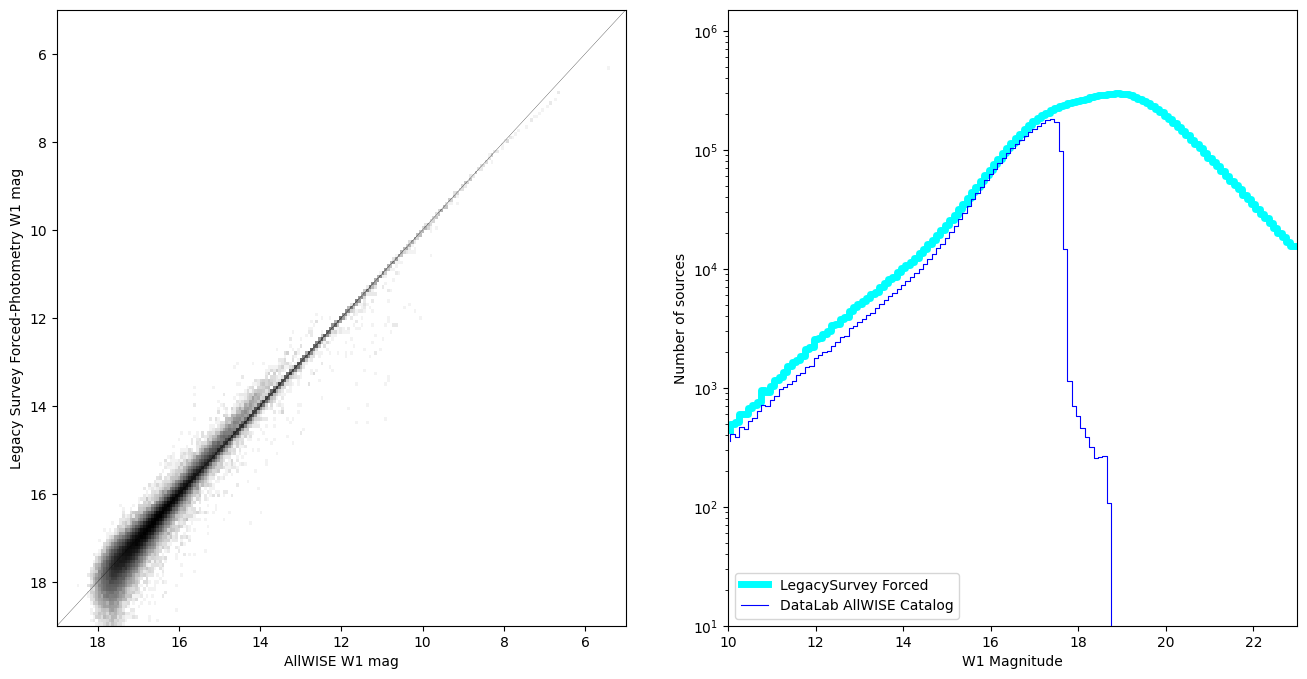

In [78]:
#font = {'size'   : 22}
fig, axs = plt.subplots(1, 2, figsize = (16, 8))
plt.subplots_adjust(wspace = 0.18, hspace = 0.18)

#LEFT side:
x_fig8a = data_awls['w1mpro']
y_fig8a = data_awls['mag_w1']
axs[0].axline([0,0], c='black', slope=1, linewidth=0.2)
axs[0].hist2d(x_fig8a,y_fig8a, bins=(300,300), norm = colors.LogNorm(), cmap = plt.cm.Greys)
axs[0].set_xlim(19.,5.)
axs[0].set_ylim(19,5.)
axs[0].set(xlabel='AllWISE W1 mag', ylabel='Legacy Survey Forced-Photometry W1 mag');

# RIGHT side:
my_bins2 = np.arange(10.,23.0001,0.1)
# We have to correct LS magnitude to get in the same reference
w1mag,bins = np.histogram(ls_w1['mag_w1']-2.699, bins=my_bins2,range = (10., 23.))
aw1mag,bins = np.histogram(aw_w1mpro['w1mpro'], bins=my_bins2,range = (10., 23.))
centers = (my_bins2[0:-1]+my_bins2[1:])/2
axs[1].set(xlabel='W1 Magnitude', ylabel='Number of sources')
axs[1].set_yscale('log')
axs[1].set_xlim(10.,23.)
axs[1].set_ylim(10,1.5E6)

axs[1].plot(centers,w1mag, c='cyan', drawstyle='steps', label='LegacySurvey Forced', lw=5.0, ls='-')
axs[1].plot(centers,aw1mag, c='blue', drawstyle='steps',label='DataLab AllWISE Catalog', lw=0.8);
axs[1].legend(loc=3,frameon=True);

<a class="anchor" id="Fig15"></a>

## Fig. 15 - Depth distribution of point sources
Now we are going to calculate the depth for each band _grz_ in DR6 and DR7 made in the original paper, and then will compare with those from DR9.

First, we build the queries to obtain the data from those 3 datasets


In [158]:
# Requires a minimun number of objects:
nmin = 1000
# Requires 90% of the image are to contain  >= 3 exposures:
npix = 0.9*900.*900. 

In [159]:
def get_colnames(band,cols=(1,2,3,4,5,6)):
    pattern = 'nexphist_%s_%d'
    colnames = [pattern % (band,col) for col in cols]
    return colnames

In [160]:
def run_query(table='ls_dr6.bricks_dr6',band='g'):
    colsall = '+'.join(get_colnames(band,(1,2,3,4,5,6)))
    colsgt3 = '+'.join(get_colnames(band,(4,5,6)))
    
    q =\
    """SELECT psfdepth_g as psfdepth FROM
         (SELECT *, t1.sumgt3 / NULLIF(t1.sumall,0.) as frac FROM
           (SELECT nexp_%s, psfdepth_%s, nobjs, %s as sumall, %s as sumgt3 FROM %s) AS t1
            WHERE nexp_%s >= 3
            AND nobjs >= %d
            AND sumall > %d) AS t2
         WHERE frac > 0.9
    """ % (band,band,colsall,colsgt3,table,band,nmin,npix)
    print(q)

    df = qc.query(q,fmt='pandas')
    return df

In [82]:
d6a = run_query(table='ls_dr6.bricks_dr6',band='g')
d7a = run_query(table='ls_dr7.bricks_dr7',band='g')
d9a = run_query(table='ls_dr9.bricks_s',band='g')

#d6a

SELECT psfdepth_g as psfdepth FROM
         (SELECT *, t1.sumgt3 / NULLIF(t1.sumall,0.) as frac FROM
           (SELECT nexp_g, psfdepth_g, nobjs, nexphist_g_1+nexphist_g_2+nexphist_g_3+nexphist_g_4+nexphist_g_5+nexphist_g_6 as sumall, nexphist_g_4+nexphist_g_5+nexphist_g_6 as sumgt3 FROM ls_dr6.bricks_dr6) AS t1
            WHERE nexp_g >= 3
            AND nobjs >= 1000
            AND sumall > 729000) AS t2
         WHERE frac>0.9
    
SELECT psfdepth_g as psfdepth FROM
         (SELECT *, t1.sumgt3 / NULLIF(t1.sumall,0.) as frac FROM
           (SELECT nexp_g, psfdepth_g, nobjs, nexphist_g_1+nexphist_g_2+nexphist_g_3+nexphist_g_4+nexphist_g_5+nexphist_g_6 as sumall, nexphist_g_4+nexphist_g_5+nexphist_g_6 as sumgt3 FROM ls_dr7.bricks_dr7) AS t1
            WHERE nexp_g >= 3
            AND nobjs >= 1000
            AND sumall > 729000) AS t2
         WHERE frac>0.9
    
SELECT psfdepth_g as psfdepth FROM
         (SELECT *, t1.sumgt3 / NULLIF(t1.sumall,0.) as frac FROM
           (S

In [161]:
# IMPORTANT: THESE ARE THE QUERIES USED TO PULL THE DATA FROM THE DATABASE BUT
# IT SHOULD BE COMMENTED OUT AND LEFT AS SUCH SINCE THESE TABLES WILL NOT BE
# SERVICED ANY MORE BY DATALAB (EXCEPT FOR query15c FOR ls_dr9)

query15a = ("""SELECT 
ra as d6ra,dec as d6dec , nexp_g as d6neg, nexp_r as d6ner, nexp_z as d6nez,
nexphist_g_1 as d6ng1,nexphist_g_2 as d6ng2,nexphist_g_3 as d6ng3,nexphist_g_4 as d6ng4,nexphist_g_5 as d6ng5,nexphist_g_6 as d6ng6,
nexphist_r_1 as d6nr1,nexphist_r_2 as d6nr2,nexphist_r_3 as d6nr3,nexphist_r_4 as d6nr4,nexphist_r_5 as d6nr5,nexphist_r_6 as d6nr6,
nexphist_z_1 as d6nz1,nexphist_z_2 as d6nz2,nexphist_z_3 as d6nz3,nexphist_z_4 as d6nz4,nexphist_z_5 as d6nz5,nexphist_z_6 as d6nz6,
psfdepth_g as d6psfdg,psfdepth_r as d6psfdr,psfdepth_z as d6psfdz,
nobjs
FROM nbdata.nb0068_lsdr6_bricks_dr6 as d6b""")
#print(query15a)
query15b = ("""SELECT 
ra as d7ra,dec as d7dec , nexp_g as d7neg, nexp_r as d7ner, nexp_z as d7nez,
nexphist_g_1 as d7ng1,nexphist_g_2 as d7ng2,nexphist_g_3 as d7ng3,nexphist_g_4 as d7ng4,nexphist_g_5 as d7ng5,nexphist_g_6 as d7ng6,
nexphist_r_1 as d7nr1,nexphist_r_2 as d7nr2,nexphist_r_3 as d7nr3,nexphist_r_4 as d7nr4,nexphist_r_5 as d7nr5,nexphist_r_6 as d7nr6,
nexphist_z_1 as d7nz1,nexphist_z_2 as d7nz2,nexphist_z_3 as d7nz3,nexphist_z_4 as d7nz4,nexphist_z_5 as d7nz5,nexphist_z_6 as d7nz6,
psfdepth_g as d7psfdg,psfdepth_r as d7psfdr,psfdepth_z as d7psfdz,
nobjs
FROM nbdata.nb0068_lsdr7_bricks_dr7 as d7b""")
#print(query15b)
query15c = ("""SELECT
ra as d9ra,dec as d9dec , nexp_g as d9neg, nexp_r as d9ner, nexp_z as d9nez,
nexphist_g_1 as d9ng1,nexphist_g_2 as d9ng2,nexphist_g_3 as d9ng3,nexphist_g_4 as d9ng4,nexphist_g_5 as d9ng5,nexphist_g_6 as d9ng6,
nexphist_r_1 as d9nr1,nexphist_r_2 as d9nr2,nexphist_r_3 as d9nr3,nexphist_r_4 as d9nr4,nexphist_r_5 as d9nr5,nexphist_r_6 as d9nr6,
nexphist_z_1 as d9nz1,nexphist_z_2 as d9nz2,nexphist_z_3 as d9nz3,nexphist_z_4 as d9nz4,nexphist_z_5 as d9nz5,nexphist_z_6 as d9nz6,
psfdepth_g as d9psfdg,psfdepth_r as d9psfdr,psfdepth_z as d9psfdz,
nobjs
FROM ls_dr9.bricks_s as d9b""")
print(query15c)

SELECT
ra as d9ra,dec as d9dec , nexp_g as d9neg, nexp_r as d9ner, nexp_z as d9nez,
nexphist_g_1 as d9ng1,nexphist_g_2 as d9ng2,nexphist_g_3 as d9ng3,nexphist_g_4 as d9ng4,nexphist_g_5 as d9ng5,nexphist_g_6 as d9ng6,
nexphist_r_1 as d9nr1,nexphist_r_2 as d9nr2,nexphist_r_3 as d9nr3,nexphist_r_4 as d9nr4,nexphist_r_5 as d9nr5,nexphist_r_6 as d9nr6,
nexphist_z_1 as d9nz1,nexphist_z_2 as d9nz2,nexphist_z_3 as d9nz3,nexphist_z_4 as d9nz4,nexphist_z_5 as d9nz5,nexphist_z_6 as d9nz6,
psfdepth_g as d9psfdg,psfdepth_r as d9psfdr,psfdepth_z as d9psfdz,
nobjs
FROM ls_dr9.bricks_s as d9b


We run the queries to obtain the data from the 3 datasets

In [162]:
# Fetch the DESI LIS data from ls_dr6.bricks_dr6 (d6), ls_dr7.bricks_dr7 (d7)
# and ls_dr9.bricks_s (d9):
d6 = qc.query(sql=query15a, fmt='pandas')
d7 = qc.query(sql=query15b, fmt='pandas')
d9 = qc.query(sql=query15c, fmt='pandas')

# Uncomment these next 3 lines in case the data has not been save to files yet
# d6.to_csv('data_fig15a.csv', encoding='utf-8', index=False)
# d7.to_csv('data_fig15b.csv', encoding='utf-8', index=False)
# d9.to_csv('data_fig15c.csv', encoding='utf-8', index=False)

There are 2 conditions established by the authors: 

1) The minimun number of counts should be 1000, and
2) That 90% of the image should be expose 3 or more times

In [163]:
# Requires a minimun number of objects:
nmin = 1000
# Requires 90% of the image are to contain  >= 3 exposures:
npix = 0.9*900.*900. 

Now we add up __ALL__ the histograms of pixels per brick per band _g,r,z_ in each of the datasets 
DR6, DR7 and we want to compare them to the latest, more complete DR9


In [164]:
total_ng6 = d6['d6ng1'] + d6['d6ng2'] + d6['d6ng3'] + d6['d6ng4'] + d6['d6ng5'] + d6['d6ng6']
total_nr6 = d6['d6nr1'] + d6['d6nr2'] + d6['d6nr3'] + d6['d6nr4'] + d6['d6nr5'] + d6['d6nr6']
total_nz6 = d6['d6nz1'] + d6['d6nz2'] + d6['d6nz3'] + d6['d6nz4'] + d6['d6nz5'] + d6['d6nz6']
total_ng7 = d7['d7ng1'] + d7['d7ng2'] + d7['d7ng3'] + d7['d7ng4'] + d7['d7ng5'] + d7['d7ng6']
total_nr7 = d7['d7nr1'] + d7['d7nr2'] + d7['d7nr3'] + d7['d7nr4'] + d7['d7nr5'] + d7['d7nr6']
total_nz7 = d7['d7nz1'] + d7['d7nz2'] + d7['d7nz3'] + d7['d7nz4'] + d7['d7nz5'] + d7['d7nz6']
total_ng9 = d9['d9ng1'] + d9['d9ng2'] + d9['d9ng3'] + d9['d9ng4'] + d9['d9ng5'] + d9['d9ng6']
total_nr9 = d9['d9nr1'] + d9['d9nr2'] + d9['d9nr3'] + d9['d9nr4'] + d9['d9nr5'] + d9['d9nr6']
total_nz9 = d9['d9nz1'] + d9['d9nz2'] + d9['d9nz3'] + d9['d9nz4'] + d9['d9nz5'] + d9['d9nz6']

Now we add up he histograms of pixels with 3 or more exposures per brick per band g,r,z in each of the datasets DR6, DR7 & DR9

In [165]:
ge3_ng6 = d6['d6ng4'] + d6['d6ng5'] + d6['d6ng6']
ge3_nr6 = d6['d6nr4'] + d6['d6nr5'] + d6['d6nr6']
ge3_nz6 = d6['d6nz4'] + d6['d6nz5'] + d6['d6nz6']
ge3_ng7 = d7['d7ng4'] + d7['d7ng5'] + d7['d7ng6'] 
ge3_nr7 = d7['d7nr4'] + d7['d7nr5'] + d7['d7nr6'] 
ge3_nz7 = d7['d7nz4'] + d7['d7nz5'] + d7['d7nz6']
ge3_ng9 = d9['d9ng4'] + d9['d9ng5'] + d9['d9ng6']
ge3_nr9 = d9['d9nr4'] + d9['d9nr5'] + d9['d9nr6']
ge3_nz9 = d9['d9nz4'] + d9['d9nz5'] + d9['d9nz6']

We then normalize to 1 to obtain a fraction of coverage per brick of each band

In [166]:
# Normalizing all sums to 1
fraction_ng6 = ge3_ng6 / total_ng6
fraction_nr6 = ge3_nr6 / total_nr6
fraction_nz6 = ge3_nz6 / total_nz6
fraction_ng7 = ge3_ng7 / total_ng7
fraction_nr7 = ge3_nr7 / total_nr7
fraction_nz7 = ge3_nz7 / total_nz7
fraction_ng9 = ge3_ng9 / total_ng9
fraction_nr9 = ge3_nr9 / total_nr9
fraction_nz9 = ge3_nz9 / total_nz9

Let's build the conditions to count as valid values in each band

In [167]:
# Conditions to consider values
cond6g = (d6['d6neg'] >= 3)  & (d6['nobjs'] >= nmin)  & (total_ng6 > npix) &  (fraction_ng6 >= 0.9)
cond6r = (d6['d6ner'] >= 3)  & (d6['nobjs'] >= nmin)  & (total_nr6 > npix) &  (fraction_nr6 >= 0.9)
cond6z = (d6['d6nez'] >= 3)  & (d6['nobjs'] >= nmin)  & (total_nz6 > npix) &  (fraction_nz6 >= 0.9)
cond7g = (d7['d7neg'] >= 3)  & (d7['nobjs'] >= nmin)  & (total_ng7 > npix) &  (fraction_ng7 >= 0.9)
cond7r = (d7['d7ner'] >= 3)  & (d7['nobjs'] >= nmin)  & (total_nr7 > npix) &  (fraction_nr7 >= 0.9)
cond7z = (d7['d7nez'] >= 3)  & (d7['nobjs'] >= nmin)  & (total_nz7 > npix) &  (fraction_nz7 >= 0.9)
cond9g = (d9['d9neg'] >= 3)  & (d9['nobjs'] >= nmin)  & (total_ng9 > npix) &  (fraction_ng9 >= 0.9)
cond9r = (d9['d9ner'] >= 3)  & (d9['nobjs'] >= nmin)  & (total_nr9 > npix) &  (fraction_nr9 >= 0.9)
cond9z = (d9['d9nez'] >= 3)  & (d9['nobjs'] >= nmin)  & (total_nz9 > npix) &  (fraction_nz9 >= 0.9)

We stablish the bin range and size 

In [168]:
my_bins = np.arange(22.5,26.0001,0.02)

Now we compute the 3 band histograms per dataset

In [169]:
cpc_g6,bins = np.histogram(d6['d6psfdg'][cond6g], bins=my_bins,range = (22.5, 26.0))
cpc_r6,bins = np.histogram(d6['d6psfdr'][cond6r], bins=my_bins,range = (22.5, 26.0))
cpc_z6,bins = np.histogram(d6['d6psfdz'][cond6z], bins=my_bins,range = (22.5, 26.0))
cpc_g7,bins = np.histogram(d7['d7psfdg'][cond7g], bins=my_bins,range = (22.5, 26.0))
cpc_r7,bins = np.histogram(d7['d7psfdr'][cond7r], bins=my_bins,range = (22.5, 26.0))
cpc_z7,bins = np.histogram(d7['d7psfdz'][cond7z], bins=my_bins,range = (22.5, 26.0))
cpc_g9,bins = np.histogram(d9['d9psfdg'][cond9g], bins=my_bins,range = (22.5, 29.0))
cpc_r9,bins = np.histogram(d9['d9psfdr'][cond9r], bins=my_bins,range = (22.5, 29.0))
cpc_z9,bins = np.histogram(d9['d9psfdz'][cond9z], bins=my_bins,range = (22.5, 29.0))

We calculate a realistic center for our bins

In [170]:
centers = (bins[0:-1]+bins[1:])/2

Calculate the cumulative sum, maximum and the fraction of each band

In [171]:
cpcf_g1 = np.cumsum(cpc_g6)
max_g6 = cpcf_g1.max()
cpcf_g1 = cpcf_g1/max_g6
cpcf_r1 = np.cumsum(cpc_r6)
max_r6 = cpcf_r1.max()
cpcf_r1 = cpcf_r1/max_r6
cpcf_z1 = np.cumsum(cpc_z6)
max_z6 = cpcf_z1.max()
cpcf_z1 = cpcf_z1/max_z6

cpcf_g2 = np.cumsum(cpc_g7)
max_g7 = cpcf_g2.max()
cpcf_g2 = cpcf_g2/max_g7
cpcf_r2 = np.cumsum(cpc_r7)
max_r7 = cpcf_r2.max()
cpcf_r2 = cpcf_r2/max_r7
cpcf_z2 = np.cumsum(cpc_z7)
max_z7 = cpcf_z2.max()
cpcf_z2 = cpcf_z2/max_z7

cpcf_g3 = np.cumsum(cpc_g9)
max_g9 = cpcf_g3.max()
cpcf_g3 = cpcf_g3/max_g9
cpcf_r3 = np.cumsum(cpc_r9)
max_r9 = cpcf_r3.max()
cpcf_r3 = cpcf_r3/max_r9
cpcf_z3 = np.cumsum(cpc_z9)
max_z9 = cpcf_z3.max()
cpcf_z3 = cpcf_z3/max_z9

Finally, we plot!

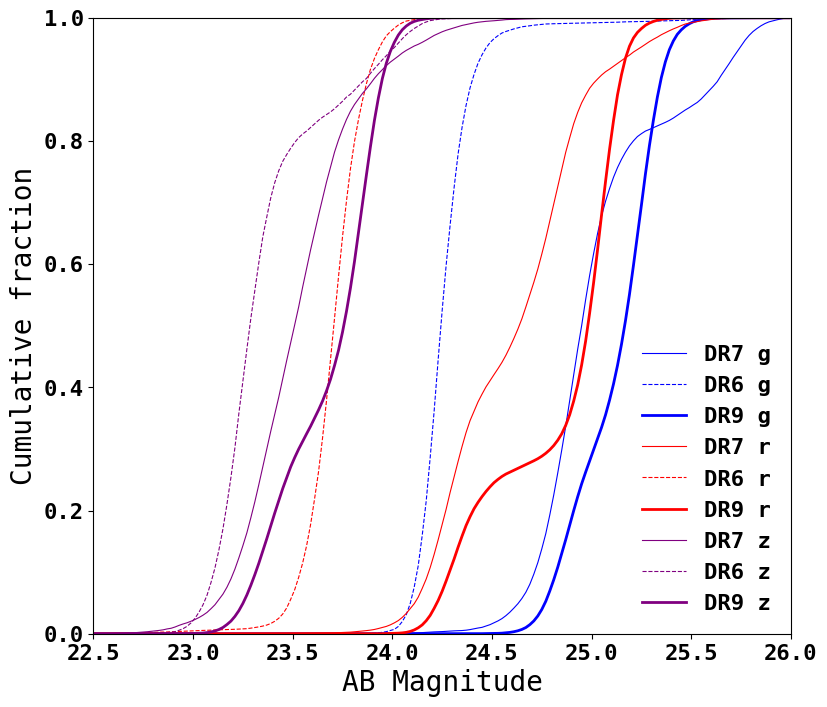

In [172]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
#fig, ax = plt.subplots()
                       
plt.figure(figsize=(9,8))
plt.xlim(22.5,26.0)
plt.ylim(0,1.)
plt.xlabel('AB Magnitude', fontsize = 20)
plt.ylabel('Cumulative fraction', fontsize = 20)
#plt.Axes.tick_params(axis='both', direction = 'in')
#ax.tick_params(axis='both', direction = 'in')
plt.plot(centers,cpcf_g2, c='blue', label='DR7 g', lw=0.8)
plt.plot(centers,cpcf_g1, c='blue', ls='dashed', label='DR6 g', lw=0.8)
plt.plot(centers,cpcf_g3, c='blue', label='DR9 g', ls='solid', lw=2)

plt.plot(centers,cpcf_r2, c='red', label='DR7 r', lw=0.8)
plt.plot(centers,cpcf_r1, c='red', ls='dashed', label='DR6 r', lw=0.8)
plt.plot(centers,cpcf_r3, c='red', label='DR9 r', ls='solid',lw=2)

plt.plot(centers,cpcf_z2, c='purple', label='DR7 z', lw=0.8)
plt.plot(centers,cpcf_z1, c='purple', ls='dashed', label='DR6 z', lw=0.8)
plt.plot(centers,cpcf_z3, c='purple', label='DR9 z',ls='solid', lw=2)

plt.legend(loc='lower right',frameon=False)
plt.show()

The curves for DR6 & DR7 above are identical to the paper's plot.

DR9 shows reaching deeper in most magnitudes, except in the very faint tail of each band, where it's more consistent and smooth.

<a class="anchor" id="Fig16"></a>
## Fig 16 - Color-color Distribution by Type of Extended Objects
In this section, we want to calculate 2d histograms of the color-color distribution, overlaying contours at different percentage levels of the number of sources in such distribution.

We start by building the query to obtain the proper data.
(TIP: Once a the query has been run with a limit of 100,000, repeat the next cell increasing the limit by 30K each time, so the sample size increases but the query won't take much longer since it uses the PostGRESQL cache. We can currently run the query with a limit of 500.000 hits under 5 mins)

In [114]:
# Fig. 16 data query. 
query_fig16a = ("""
SELECT r_z, g_r, z_w1, type 
FROM nbdata.nb0068_lsdr7_tractor 
WHERE (type = 'EXP' or type = 'DEV' or type = 'PSF') AND
(r_z != 'inf' and r_z != 'nan') AND
(g_r != 'inf' and g_r != 'nan') AND
(z_w1 != 'inf' and z_w1 != 'nan') AND
random_id BETWEEN 11. AND 11.4
LIMIT 560000
""")
print(query_fig16a)


SELECT r_z, g_r, z_w1, type 
FROM nbdata.nb0068_lsdr7_tractor 
WHERE (type = 'EXP' or type = 'DEV' or type = 'PSF') AND
(r_z != 'inf' and r_z != 'nan') AND
(g_r != 'inf' and g_r != 'nan') AND
(z_w1 != 'inf' and z_w1 != 'nan') AND
random_id BETWEEN 11. AND 11.4
LIMIT 560000



Fetch the data from the __tractor__ table in DR7

In [115]:
# Next line to be commented out once the tables are offline
df16 = qc.query(sql=query_fig16a, fmt='pandas')
# Next line to be uncommented once the tables are offline
#color_type = Table.read(data16, format='pandas')

df16[:10]

,r_z,g_r,z_w1,type
0,0.079756,0.353277,-1.703598,PSF
1,0.949818,1.429455,0.788786,EXP
2,1.057819,0.778284,1.160572,EXP
3,0.315361,0.660346,-1.128406,PSF
4,0.961868,1.750929,0.748854,DEV
5,0.488331,0.615242,-2.299334,EXP
6,0.689764,0.856829,-0.822039,DEV
7,0.123289,0.852541,0.513186,EXP
8,0.960089,1.689152,0.649431,DEV
9,1.326546,0.688177,1.507547,EXP


Checking the lenght and a few rows of the data frame

In [116]:
len(df16)

560000

In [117]:
df16['g_r']

0         0.353277
1         1.429455
2         0.778284
3         0.660346
4         1.750929
            ...   
559995    0.766481
559996    0.505487
559997    0.996283
559998    1.548008
559999    0.356308
Name: g_r, Length: 560000, dtype: float64

Here we finally plot our 2d histograms and distribution contours.

Choosing the levels for the contours varies for one plot to the next. We wanted to represent them as close as we could to the original plot in the paper.

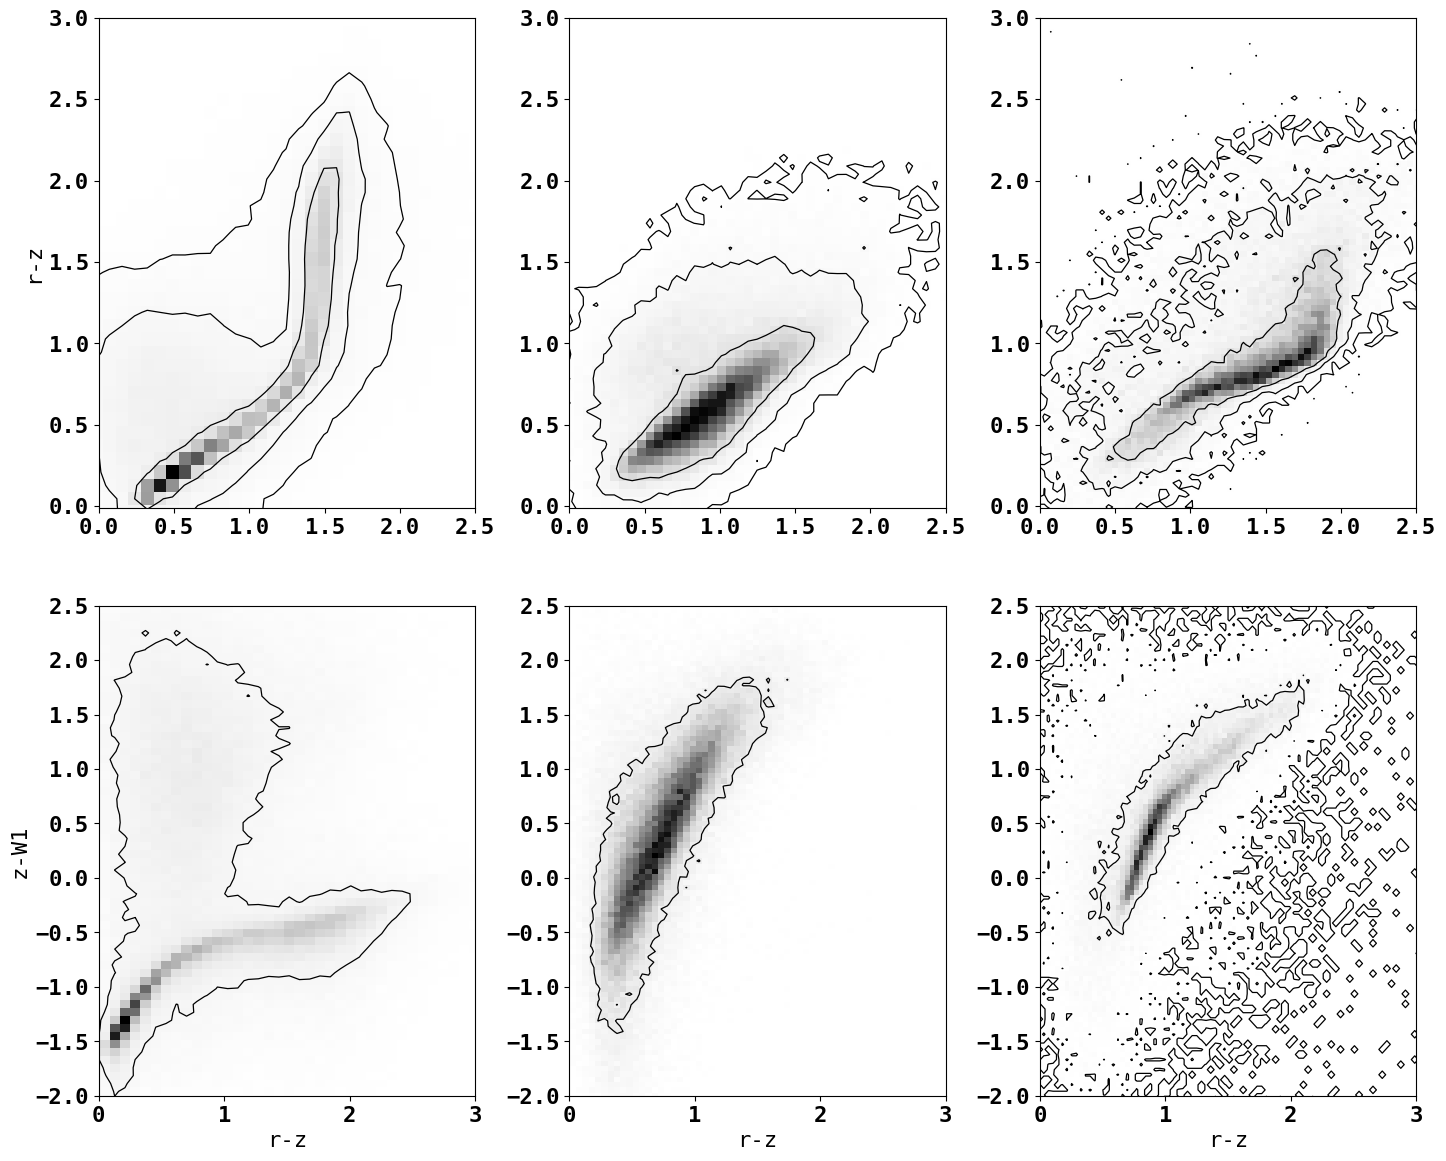

In [120]:
#def plot_panel(ax,x,y,xlims,ylims,xlabel='',ylabel='',levels=(0.05,0.09)):
def plot_panel(ax,x,y,xlims,ylims,xlabel='',ylabel='',levels=()):
    h,x_edges,y_edges,im = ax.hist2d(x,y, bins=400, norm = colors.Normalize(), cmap = plt.cm.Greys)
    levels = np.array((levels)) * h.max()
    x_centers = 0.5*(x_edges[1:] + x_edges[:-1])
    y_centers = 0.5*(y_edges[1:] + y_edges[:-1])
    ax.contour(x_centers,y_centers,h.T,origin='lower', levels=levels, colors=('k','k'), linewidths=0.9)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

cond1 = (df16['type'] == 'PSF')
cond2 = (df16['type'] == 'EXP')
cond3 = (df16['type'] == 'DEV')

fig, axs = plt.subplots(2, 3, figsize = (17, 14))
plt.subplots_adjust(wspace = 0.25, hspace = 0.2)

plot_panel(ax=axs[0,0],x=df16['g_r'][cond1],y=df16['r_z'][cond1],levels=np.array((0.022,0.055, 0.17)),xlims=(0,2.5),ylims=(-0.01,3),xlabel='',ylabel='r-z')
plot_panel(ax=axs[0,1],x=df16['g_r'][cond2],y=df16['r_z'][cond2],levels=np.array((0.008,0.05, 0.2)),xlims=(0,2.5),ylims=(-0.01,3),xlabel='',ylabel='')
plot_panel(ax=axs[0,2],x=df16['g_r'][cond3],y=df16['r_z'][cond3],levels=np.array((0.01,0.05, 0.2)),xlims=(0,2.5),ylims=(-0.01,3),xlabel='',ylabel='')
plot_panel(ax=axs[1,0],x=df16['r_z'][cond1],y=df16['z_w1'][cond1],levels=np.array((-20,0.075)),xlims=(0,3),ylims=(-2,2.5),xlabel='r-z',ylabel='z-W1')
plot_panel(ax=axs[1,1],x=df16['r_z'][cond2],y=df16['z_w1'][cond2],levels=np.array((-20,0.13)),xlims=(0,3),ylims=(-2,2.5),xlabel='r-z',ylabel='')
plot_panel(ax=axs[1,2],x=df16['r_z'][cond3],y=df16['z_w1'][cond3],levels=np.array((0.0012, 0.08)),xlims=(0,3),ylims=(-2,2.5),xlabel='r-z',ylabel='')

<a class="anchor" id="resources"></a>
# Resources and references

Dey, A. et al. (2019, AJ, 157, 168), "Overview of the DESI Legacy Imaging Surveys" https://ui.adsabs.harvard.edu/abs/2019AJ....157..168D/abstract